首先我们载入需要的类库

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles

In [3]:
plt.style.use("seaborn")

接着我们生成一些随机数据来做二元分类，如果对如何产生随机数据不熟悉，在另一篇文章机器学习算法的随机数据生成中有比较详细的介绍。

In [4]:
# 生成2维正态分布，生成的数据按分位数分为两类，500个样本,2个样本特征，协方差系数为2
X1, y1 = make_gaussian_quantiles(cov=2.0,
                                 n_samples=500,
                                 n_features=2,
                                 n_classes=2,
                                 random_state=1)
# 生成2维正态分布，生成的数据按分位数分为两类，400个样本,2个样本特征均值都为3，协方差系数为2
X2, y2 = make_gaussian_quantiles(mean=(3, 3),
                                 cov=1.5,
                                 n_samples=400,
                                 n_features=2,
                                 n_classes=2,
                                 random_state=1)
#讲两组数据合成一组数据
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

In [5]:
X

array([[ 2.69359418,  1.57127145],
       [-1.34129623, -0.59888875],
       [-1.14388268,  0.78833843],
       ...,
       [ 4.49166687,  0.62316094],
       [-0.06975033,  0.41068858],
       [ 1.6858925 ,  3.60644297]])

我们通过可视化看看我们的分类数据，它有两个特征，两个输出类别，用颜色区别。

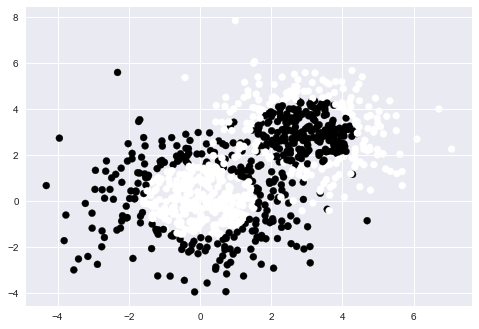

In [10]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

可以看到数据有些混杂，我们现在用基于决策树的Adaboost来做分类拟合。

In [11]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20,
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=200,
                         learning_rate=0.8)
bdt.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                           

这里我们选择了SAMME算法，最多200个弱分类器，步长0.8，在实际运用中你可能需要通过交叉验证调参而选择最好的参数。拟合完了后，我们用网格图来看看它拟合的区域。

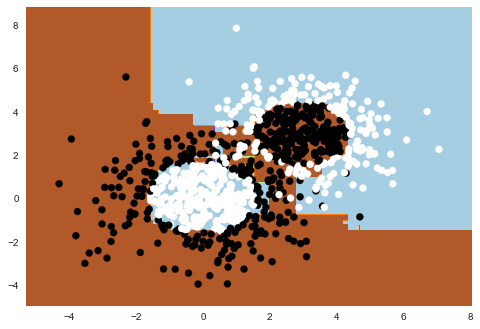

In [12]:
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
plt.show()

从图中可以看出，Adaboost的拟合效果还是不错的，现在我们看看拟合分数：

In [13]:
print("Score:", bdt.score(X,y))

Score: 0.9133333333333333


也就是说拟合训练集数据的分数还不错。当然分数高并不一定好，因为可能过拟合。
现在我们将最大弱分离器个数从200增加到300。再来看看拟合分数。

In [14]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20,
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=300,
                         learning_rate=0.8)
bdt.fit(X, y)
print("Score:", bdt.score(X, y))

Score: 0.9622222222222222


这印证了我们前面讲的，弱分离器个数越多，则拟合程度越好，当然也越容易过拟合。

现在我们降低步长，将步长从上面的0.8减少到0.5，再来看看拟合分数。

In [16]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20,
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=300,
                         learning_rate=0.5)
bdt.fit(X, y)
print("Score:", bdt.score(X, y))

Score: 0.8944444444444445


可见在同样的弱分类器的个数情况下，如果减少步长，拟合效果会下降。

最后我们看看当弱分类器个数为700，步长为0.7时候的情况：

In [17]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2,
                                                min_samples_split=20,
                                                min_samples_leaf=5),
                         algorithm="SAMME",
                         n_estimators=600,
                         learning_rate=0.7)
bdt.fit(X, y)
print("Score:", bdt.score(X, y))

Score: 0.9611111111111111


此时的拟合分数和我们最初的300弱分类器，0.8步长的拟合程度相当。也就是说，在我们这个例子中，如果步长从0.8降到0.7，则弱分类器个数要从300增加到700才能达到类似的拟合效果。